In [1]:
using Revise

In [2]:
using QuantumStates, UnitsToValue, DataFrames

### Load Hamiltonian

In [3]:
H = load_from_file("CaOH_BendingMode_Hamiltonian", "C://Google Drive//github//QuantumStates//Hamiltonians//CaOH//")

# Add AC Stark effect from trap
au = 1.64877727436e-41
w = 2.2e-6; P = @with_unit 0.150 "W"; I_trap = 2P / (π * w^2);
α_par = 186.5
α_perp = 393.2
const α = [(1/3)*(α_par + 2α_perp), 0, (2/3)*(α_par - α_perp)] .* au
const θ = 0.304π
const ϵ_trap = cos(θ) * [0.0, 1.0, 0.0] + sin(θ) * [1.0, 0.0, -1.0] / √2
scalar_polarizability(state, state′) = polarizability(state, state′, α .* [1,0,0], ϵ_trap)
tensor_polarizability(state, state′) = polarizability(state, state′, α .* [0,0,1], ϵ_trap)
H = add_to_H(H, :I_scalar, (1e-6 / h) * scalar_polarizability)
H = add_to_H(H, :I_tensor, (1e-6 / h) * tensor_polarizability)

# Add DC Stark effect
const μX = 1e-6 * 1.465 * (1e-21 / c) / h
H = add_to_H(H, :E, (1e2 * μX) * Stark) # 1e2 converts from V/m to V/cm

# Add Zeeman effect
Zeeman_z(state, state′) = Zeeman(state, state′, 0)
H = add_to_H(H, :B_z, gS * (1e-10 * μ_B / h) * Zeeman_z)
;

LoadError: UndefVarError: `#42#44` not defined

In [4]:
H.parameters.E = 0.
H.parameters.B_z = 1e-6
H.parameters.I_scalar = 0I_trap
H.parameters.I_tensor = 0I_trap
full_evaluate!(H)
solve!(H)
N1_idxs, N1_states = subspace(H.states, (N=1,))
;

LoadError: UndefVarError: `H` not defined

In [5]:
QN_bounds = (S = 1/2, I = 1/2, Λ = [-1,1], N = 1:3)
basis_uncoupled = enumerate_states(HundsCaseB_Decoupled, QN_bounds)
N1_states_uncoupled = convert_basis(N1_states, basis_uncoupled)
;

LoadError: UndefVarError: `N1_states` not defined

In [6]:
# |0⟩ state
idx_0 = 12
state = N1_states_uncoupled[idx_0]
1e-3 * (1e2 * μX) * 1e6 * d(N1_states[idx_0], N1_states[idx_0]) |> display
1e-3 * gS * (1e-4 * μ_B / h) * TDM_magnetic(N1_states[idx_0], N1_states[idx_0], 0) |> display
state |> display
energy(state) |> display

LoadError: UndefVarError: `N1_states_uncoupled` not defined

In [7]:
# |1⟩ state
idx_1 = 24
state = N1_states_uncoupled[idx_1]
d(N1_states[idx_1], N1_states[idx_1]) |> display
1e-3 * gS * (1e-4 * μ_B / h) * TDM_magnetic(N1_states[idx_1], N1_states[idx_1], 0) |> display
state |> display
energy(state) |> display

LoadError: UndefVarError: `N1_states_uncoupled` not defined

In [8]:
# |e⟩ state
idx_e = 3
state = N1_states_uncoupled[idx_e]
d(N1_states[idx_e], N1_states[idx_e]) |> display
1e-3 * gS * (1e-4 * μ_B / h) * TDM_magnetic(N1_states[idx_e], N1_states[idx_e], 0) |> display
state |> display
energy(state) |> display

LoadError: UndefVarError: `N1_states_uncoupled` not defined

In [9]:
TDM(N1_states[idx_1], N1_states[idx_1], 0) |> display
TDM(N1_states[idx_0], N1_states[idx_1], 0) |> display
TDM(N1_states[idx_0], N1_states[idx_0], 0) |> display
TDM(N1_states[idx_0], N1_states[idx_e], 0) |> display
TDM(N1_states[idx_e], N1_states[idx_e], 0) |> display

LoadError: UndefVarError: `N1_states` not defined

In [10]:
# 1-qubit gate Rabi transition frequency
energy(N1_states[idx_1]) - energy(N1_states[idx_0])

LoadError: UndefVarError: `N1_states` not defined

In [11]:
# 2-qubit gate Rabi transition frequency
energy(N1_states[idx_0]) - energy(N1_states[idx_e])

LoadError: UndefVarError: `N1_states` not defined

In [12]:
using Plots
hline(energy.(N1_states), legend=nothing)
plot!(
    xticks=nothing,
    ylabel="Energy (MHz)",
)

LoadError: UndefVarError: `N1_states` not defined

### Create table of transitions

In [13]:
using PrettyTables

In [14]:
@time transitions = compute_transitions(N1_states, N1_states, 0, threshold=1e-13)
df = transitions_table(transitions)
df = select(df, [:M, :M_1, :f, :tdm])
df = df[df.M .== 0, :]
df = df[df.M_1 .== 0, :]

highlighters = (
    hl_row(2, crayon"bg:yellow bold"),
    hl_row(12, crayon"bg:green bold")
    )
pretty_table(df; nosubheader=true, highlighters=highlighters)

LoadError: UndefVarError: `N1_states` not defined

### Stark plots

In [99]:
function H_func!(H, scan_values)
    H.parameters.E = scan_values[1]
    evaluate!(H)
    solve!(H)
    return nothing
end
;

In [100]:
Es = H.parameters.E .+ (-1:0.01:1) .* 1e-3
scan_params = (
    E = Es,
    );
iterator = Iterators.product
@time scan_values, tracked_idxs = scan_parameters(deepcopy(H), scan_params, iterator, H_func!, H -> energy.(H.states), n_threads=10)
matrix_values = hcat(values(scan_values)...)'
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


  1.181952 seconds (400.33 k allocations: 273.873 MiB, 91.12% compilation time)


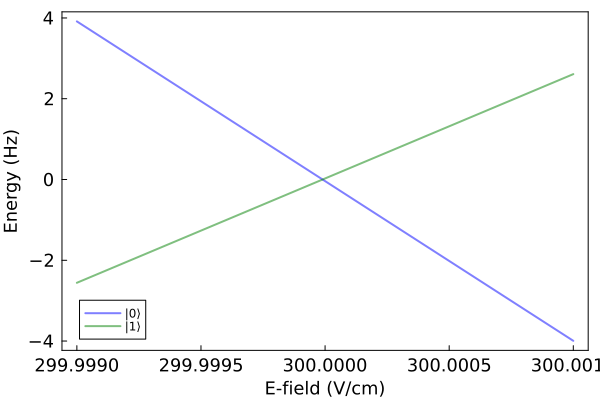

In [106]:
using Plots, LaTeXStrings
Es_rel = matrix_values .- matrix_values[round(Int, end/2),:]'
plot(Es, 1e6 .* Es_rel[:,idx_0], linewidth=2, linecolor=:blue, alpha=0.5, label="|0⟩")
plot!(Es, 1e6 .* Es_rel[:,idx_1], linewidth=2, linecolor=:green, alpha=0.5, label="|1⟩")
# plot!(Es, 1e6 .* Es_rel[:,idx_e], linewidth=2, linecolor=:red, alpha=0.5, label="|e⟩")
plot!(
    xlabel="E-field (V/cm)",
    ylabel="Energy (Hz)",
    labelfontsize=12,
    tickfontsize=12,
    grid=:off,
    box=:on
)

### Zeeman plots

In [18]:
function H_func!(H, scan_values)
    H.parameters.B_z = scan_values[1]
    evaluate!(H)
    solve!(H)
    return nothing
end
;

In [19]:
Bs = (0:0.01:1) .* 1e-3
scan_params = (
    B = Bs,
    );
iterator = Iterators.product
@time scan_values, tracked_idxs = scan_parameters(deepcopy(H), scan_params, iterator, H_func!, H -> energy.(H.states), n_threads=10)
matrix_values = hcat(values(scan_values)...)'
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


  5.038502 seconds (337.87 k allocations: 180.576 MiB, 0.72% gc time, 108.76% compilation time)


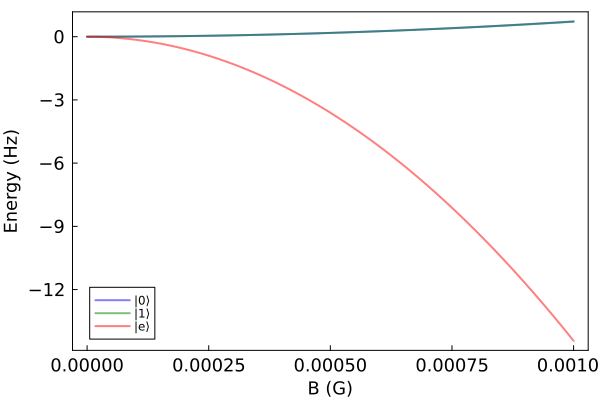

In [22]:
using Plots, LaTeXStrings
Es_rel = matrix_values .- matrix_values[1,:]'
plot(Bs, 1e6 .* Es_rel[:,idx_0], linewidth=2, linecolor=:blue, alpha=0.5, label="|0⟩")
plot!(Bs, 1e6 .* Es_rel[:,idx_1], linewidth=2, linecolor=:green, alpha=0.5, label="|1⟩")
plot!(Bs, 1e6 .* Es_rel[:,idx_e], linewidth=2, linecolor=:red, alpha=0.5, label="|e⟩")
plot!(
    xlabel="B (G)",
    ylabel="Energy (Hz)",
    labelfontsize=12,
    tickfontsize=12,
    grid=:off,
    box=:on
    )

### Trap shift plots

In [23]:
function H_func!(H, scan_values)
    H.parameters.I_scalar = scan_values[1]
    H.parameters.I_tensor = scan_values[1]
    evaluate!(H)
    solve!(H)
    return nothing
end
;

In [24]:
Is = (0:0.01:1.0) .* I_trap
scan_params = (
    I = Is,
    );
iterator = Iterators.product
@time scan_values, _ = scan_parameters(deepcopy(H), scan_params, iterator, H_func!, H -> energy.(H.states), n_threads=10)
matrix_values = hcat(values(scan_values)...)'
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


  2.204688 seconds (306.08 k allocations: 178.277 MiB, 2.28% gc time, 73.21% compilation time)


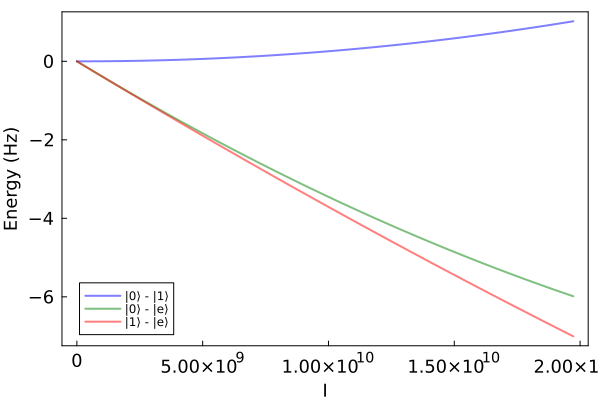

In [25]:
using Plots, LaTeXStrings
Es_rel = matrix_values .- matrix_values[1,:]'
plot(Is, 1e6 .* (Es_rel[:,idx_0] .- Es_rel[:,idx_1]), linewidth=2, linecolor=:blue, alpha=0.5, label="|0⟩ - |1⟩")
plot!(Is, 1e6 .* (Es_rel[:,idx_0] .- Es_rel[:,idx_e]), linewidth=2, linecolor=:green, alpha=0.5, label="|0⟩ - |e⟩")
plot!(Is, 1e6 .* (Es_rel[:,idx_1] .- Es_rel[:,idx_e]), linewidth=2, linecolor=:red, alpha=0.5, label="|1⟩ - |e⟩")
plot!(
    xlabel="I",
    ylabel="Energy (Hz)",
    labelfontsize=12,
    tickfontsize=12,
    grid=:off,
    box=:on
    )